Imports

In [117]:
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
pd.set_option('display.max_columns', None)
from tensorflow import keras
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import *
from sklearn.model_selection import train_test_split 
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import EarlyStopping

Load Data

In [118]:
df_train = pd.read_pickle("TrainingDataFinalized.pkl")

df_test = pd.read_pickle("TestDataFinalized.pkl")


In [119]:
df_train.drop(labels="index",axis=1,inplace=True)
df_test.drop(labels="index",axis=1,inplace=True)

In [120]:
y_train = df_train['Litres']
#y_test = df_test['Litres']
X_train = df_train.drop(labels=['Litres','WeekStarting',"Customer"],axis=1)
X_test = df_test.drop(labels=['Litres','WeekStarting',"Customer"],axis=1)


In [121]:
df_train.columns

Index(['Customer', 'WeekStarting', 'Litres', 'Price(t-1)', 'NewCars',
       'WeekendHolidays', 'WeekdayHolidays', 'GDPGrowth%', 'MoMInflation%',
       'WoWUSDChange%', 'Litres(w-52)', 'Litres(w-53)', 'Litres(w-54)',
       'Litres(w-52_average_city)', 'Litres(w-53_average_city)',
       'Litres(w-54_average_city)', 'Litres(w-52_average_area)',
       'Litres(w-53_average_area)', 'Litres(w-54_average_area)', 'WeekNumber',
       'Benzin', 'Motorin', 'Akdeniz Bölgesi', 'Doğu Anadolu Bölgesi',
       'Ege Bölgesi', 'Güneydoğu Anadolu Bölgesi', 'Karadeniz Bölgesi',
       'Marmara Bölgesi', 'İç Anadolu Bölgesi', 'Autumn', 'Fall', 'Summer',
       'Winter'],
      dtype='object')

Performance Plotting Functions

In [122]:
def model_evolution_loss(history):  
    # summarize history for loss
    plt.ylim(0,4)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

# Evaluate accuracy on training set
def test_set_evalution(model, X_train, X_valid, y_train, y_valid):
    print("Train set evaluation:", model.evaluate(X_train,y_train))
    print("Test set evaluation:", model.evaluate(X_valid,y_valid))

In [123]:
X_train.shape

(380886, 30)

Train Validation split

In [124]:
from sklearn.model_selection import train_test_split 
X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train,test_size=0.1)

Design NN

In [178]:
model = Sequential()

# hidden layers

model.add(Dense(units=25, activation='relu', input_dim=30))
model.add(Dense(units=25,activation='relu'))
model.add(Dense(units=25,activation='relu'))
model.add(Dense(units=20,activation='relu'))


# final layer
model.add(Dense(units=1,activation='linear'))

# Define custom optmizer?
#from keras.optimizers import SGD
#opt = SGD(learning_rate=0.1, momentum=0.9)

# Compile model
model.compile(loss="MeanSquaredLogarithmicError", optimizer='adam',metrics=['MeanSquaredLogarithmicError'])


In [179]:
# Train NN
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=15, batch_size = 512,validation_data=(X_valid,y_valid), verbose=1,callbacks=[early_stopping])

Epoch 1/15
670/670 [==============================] - 3s 4ms/step - loss: 22.0866 - mean_squared_logarithmic_error: 22.0866 - val_loss: 3.6189 - val_mean_squared_logarithmic_error: 3.6189
Epoch 2/15
670/670 [==============================] - 3s 4ms/step - loss: 2.2273 - mean_squared_logarithmic_error: 2.2273 - val_loss: 1.6492 - val_mean_squared_logarithmic_error: 1.6492
Epoch 3/15
670/670 [==============================] - 3s 4ms/step - loss: 1.4655 - mean_squared_logarithmic_error: 1.4655 - val_loss: 1.3558 - val_mean_squared_logarithmic_error: 1.3558
Epoch 4/15
670/670 [==============================] - 3s 4ms/step - loss: 1.2908 - mean_squared_logarithmic_error: 1.2908 - val_loss: 1.2438 - val_mean_squared_logarithmic_error: 1.2438
Epoch 5/15
670/670 [==============================] - 3s 4ms/step - loss: 1.1961 - mean_squared_logarithmic_error: 1.1961 - val_loss: 1.1625 - val_mean_squared_logarithmic_error: 1.1625
Epoch 6/15
670/670 [==============================] - 2s 4ms/step - 

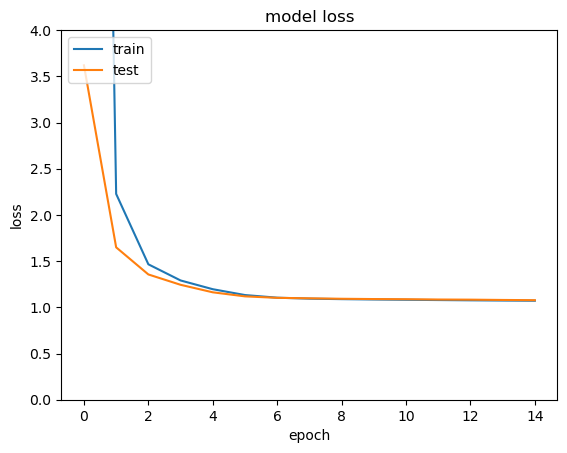

10713/10713 [==============================] - 25s 2ms/step - loss: 1.0693 - mean_squared_logarithmic_error: 1.0693
Train set evaluation: [1.0693284273147583, 1.0693284273147583]
1191/1191 [==============================] - 3s 2ms/step - loss: 1.0773 - mean_squared_logarithmic_error: 1.0773
Test set evaluation: [1.077284812927246, 1.077284812927246]


In [180]:
# Plot model evolution
model_evolution_loss(history)

# print metrics
test_set_evalution(model, X_train, X_valid, y_train, y_valid)

In [181]:
X_test

,Price(t-1),NewCars,WeekendHolidays,WeekdayHolidays,GDPGrowth%,MoMInflation%,WoWUSDChange%,Litres(w-52),Litres(w-53),Litres(w-54),Litres(w-52_average_city),Litres(w-53_average_city),Litres(w-54_average_city),Litres(w-52_average_area),Litres(w-53_average_area),Litres(w-54_average_area),WeekNumber,Benzin,Motorin,Akdeniz Bölgesi,Doğu Anadolu Bölgesi,Ege Bölgesi,Güneydoğu Anadolu Bölgesi,Karadeniz Bölgesi,Marmara Bölgesi,İç Anadolu Bölgesi,Autumn,Fall,Summer,Winter
0,0.483655,-0.928038,-0.258993,-0.297366,-0.432797,-2.308738,0.726985,0.172202,-0.254425,0.116420,-0.028372,-0.416127,-0.146568,-0.065210,0.062237,0.178364,-1.692805,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.649890,-0.928038,-0.258993,-0.297366,-0.432797,-1.308993,-1.031238,-0.184247,0.173840,-0.253397,-0.421523,-0.026230,-0.414405,0.062026,-0.062741,0.065273,-1.625150,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.834596,-0.928038,-0.258993,-0.297366,-0.432797,-1.308993,-0.582085,0.143064,-0.182925,0.175663,-0.194083,-0.420193,-0.023798,0.317206,0.064783,-0.059959,-1.557495,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.834596,-0.968046,-0.258993,-0.297366,-0.432797,-1.308993,-0.593602,-0.397728,0.144676,-0.181765,-0.428336,-0.192284,-0.418478,-0.038918,0.320541,0.067824,-1.489840,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.834596,-0.968046,-0.258993,-0.297366,-0.432797,-1.308993,0.135792,-0.101354,-0.396596,0.146445,-0.365501,-0.427021,-0.190153,-0.121680,-0.036390,0.324101,-1.422185,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108467,1.758123,-1.030611,-0.258993,-0.297366,-1.298997,0.998109,0.047497,-0.760692,-0.785261,-0.760689,-1.000799,-1.034750,-1.001211,-1.158219,-1.173811,-1.145583,1.486987,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
108468,1.758123,-1.030611,-0.258993,-0.297366,-0.628391,0.998109,0.059014,-0.774912,-0.759881,-0.785219,-1.019873,-1.000666,-1.034154,-1.097932,-1.158227,-1.173283,1.554642,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
108469,1.758123,-1.030611,-0.258993,-0.297366,-0.628391,-0.559185,0.696274,-0.704698,-0.774114,-0.759793,-0.925689,-1.019780,-1.000008,-1.175294,-1.097803,-1.157668,1.622298,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
108470,1.758123,-1.030611,-0.258993,-0.297366,-0.628391,-0.559185,-0.063831,-0.805671,-0.703838,-0.774052,-1.061134,-0.925401,-1.019157,-1.130332,-1.175340,-1.097121,1.689953,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [182]:
df_test

,Customer,WeekStarting,Litres,Price(t-1),NewCars,WeekendHolidays,WeekdayHolidays,GDPGrowth%,MoMInflation%,WoWUSDChange%,Litres(w-52),Litres(w-53),Litres(w-54),Litres(w-52_average_city),Litres(w-53_average_city),Litres(w-54_average_city),Litres(w-52_average_area),Litres(w-53_average_area),Litres(w-54_average_area),WeekNumber,Benzin,Motorin,Akdeniz Bölgesi,Doğu Anadolu Bölgesi,Ege Bölgesi,Güneydoğu Anadolu Bölgesi,Karadeniz Bölgesi,Marmara Bölgesi,İç Anadolu Bölgesi,Autumn,Fall,Summer,Winter
0,10048261,2019-01-07,NaN,0.483655,-0.928038,-0.258993,-0.297366,-0.432797,-2.308738,0.726985,0.172202,-0.254425,0.116420,-0.028372,-0.416127,-0.146568,-0.065210,0.062237,0.178364,-1.692805,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,10048261,2019-01-14,NaN,0.649890,-0.928038,-0.258993,-0.297366,-0.432797,-1.308993,-1.031238,-0.184247,0.173840,-0.253397,-0.421523,-0.026230,-0.414405,0.062026,-0.062741,0.065273,-1.625150,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,10048261,2019-01-21,NaN,0.834596,-0.928038,-0.258993,-0.297366,-0.432797,-1.308993,-0.582085,0.143064,-0.182925,0.175663,-0.194083,-0.420193,-0.023798,0.317206,0.064783,-0.059959,-1.557495,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,10048261,2019-01-28,NaN,0.834596,-0.968046,-0.258993,-0.297366,-0.432797,-1.308993,-0.593602,-0.397728,0.144676,-0.181765,-0.428336,-0.192284,-0.418478,-0.038918,0.320541,0.067824,-1.489840,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,10048261,2019-02-04,NaN,0.834596,-0.968046,-0.258993,-0.297366,-0.432797,-1.308993,0.135792,-0.101354,-0.396596,0.146445,-0.365501,-0.427021,-0.190153,-0.121680,-0.036390,0.324101,-1.422185,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108467,12739737,2019-12-02,NaN,1.758123,-1.030611,-0.258993,-0.297366,-1.298997,0.998109,0.047497,-0.760692,-0.785261,-0.760689,-1.000799,-1.034750,-1.001211,-1.158219,-1.173811,-1.145583,1.486987,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
108468,12739737,2019-12-09,NaN,1.758123,-1.030611,-0.258993,-0.297366,-0.628391,0.998109,0.059014,-0.774912,-0.759881,-0.785219,-1.019873,-1.000666,-1.034154,-1.097932,-1.158227,-1.173283,1.554642,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
108469,12739737,2019-12-16,NaN,1.758123,-1.030611,-0.258993,-0.297366,-0.628391,-0.559185,0.696274,-0.704698,-0.774114,-0.759793,-0.925689,-1.019780,-1.000008,-1.175294,-1.097803,-1.157668,1.622298,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
108470,12739737,2019-12-23,NaN,1.758123,-1.030611,-0.258993,-0.297366,-0.628391,-0.559185,-0.063831,-0.805671,-0.703838,-0.774052,-1.061134,-0.925401,-1.019157,-1.130332,-1.175340,-1.097121,1.689953,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Check that my X_test is the same order as as the original test data

In [183]:
df_test_og = pd.read_csv("test.csv")

In [184]:
(df_test_og.Customer == df_test.Customer).sum()

108472

## Now do prediction

In [185]:
y_test_pred = model.predict(X_test)

3390/3390 [==============================] - 5s 1ms/step


In [186]:
y_test_pred

array([[35554.652 ],
       [30019.07  ],
       [37152.664 ],
       ...,
       [ 6989.2544],
       [ 7607.9707],
       [ 6932.102 ]], dtype=float32)

In [187]:
n = len(y_test_pred)

In [188]:
index_values = np.linspace(0,n-1,n)

In [165]:
df_pred = pd.DataFrame(data = y_test_pred)
  

In [173]:
df_pred.columns=["Litres"]
df_pred.index.name = 'index'

In [174]:
df_pred.to_csv("MyTestSubmission.csv")